# Training model
## Load from Gold layer

In [1]:
from datetime import datetime
from typing import List, Optional, Tuple

from pyspark.sql import SparkSession, DataFrame # type: ignore
from pyspark.sql.functions import col, to_timestamp, year, month # type: ignore
from functools import reduce
import os
import datetime

SOURCE_CATALOG = "datalake"
SOURCE_NAMESPACE = f"{SOURCE_CATALOG}.gold"
TARGET_CATALOG = "datalake"
TARGET_NAMESPACE = f"{TARGET_CATALOG}.gold"
FINANCIAL_COLUMNS = ["price"]
DATE_COLUMN = "Date"
BASE_PREDICT_PATH = '/src/data/predict'
BASE_FUTURE_PATH = '/src/data/future'
BASE_MODEL_PATH = '/src/model'
today = datetime.date.today()
today = today.strftime('%d_%m_%Y')

In [2]:
spark = (
        SparkSession.builder.appName("Test_read")
        .enableHiveSupport()
        .config("spark.sql.parquet.datetimeRebaseModeInWrite", "CORRECTED")
        .config("spark.sql.avro.datetimeRebaseModeInWrite", "CORRECTED")
        .getOrCreate()
    )
spark.sql(f"CREATE NAMESPACE IF NOT EXISTS {TARGET_NAMESPACE}")

DataFrame[]

## Read Gold Tables

In [3]:
# Read silver tables
try:
    merged_data = spark.table("datalake.gold.macro")
    
    print("Tables loaded successfully")
except Exception as e:
    print(f"Error loading silver tables: {e}")

Tables loaded successfully


In [4]:
# Display table schemas and sample data
print("Merge data schema:")
merged_data.printSchema()
merged_data.show(5)

Merge data schema:
root
 |-- date: timestamp (nullable = true)
 |-- gold: float (nullable = true)
 |-- oil: float (nullable = true)
 |-- us_dollar: float (nullable = true)
 |-- usd_vnd: float (nullable = true)
 |-- cpi: float (nullable = true)
 |-- inflation_rate: float (nullable = true)
 |-- interest_rate: float (nullable = true)
 |-- id: long (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)



SLF4J: Failed to load class "org.slf4j.impl.StaticLoggerBinder".
SLF4J: Defaulting to no-operation (NOP) logger implementation
SLF4J: See http://www.slf4j.org/codes.html#StaticLoggerBinder for further details.
                                                                                

+-------------------+-----+-----+---------+-------+-----+--------------+-------------+----+----+-----+
|               date| gold|  oil|us_dollar|usd_vnd|  cpi|inflation_rate|interest_rate|  id|year|month|
+-------------------+-----+-----+---------+-------+-----+--------------+-------------+----+----+-----+
|2002-10-04 00:00:00|323.3|29.62|   108.02|15340.0|181.2|           0.2|         1.75|2830|2002|   10|
|2002-10-07 00:00:00|323.1|29.64|    107.9|15344.0|181.2|           0.2|         1.75|2833|2002|   10|
|2002-10-09 00:00:00|320.8|29.35|   107.26|15347.0|181.2|           0.2|         1.75|2835|2002|   10|
|2002-10-10 00:00:00|317.4|28.97|    107.6|15349.0|181.2|           0.2|         1.75|2836|2002|   10|
|2002-10-12 00:00:00|317.2|29.37|    107.6|15348.0|181.2|           0.2|         1.75|2838|2002|   10|
+-------------------+-----+-----+---------+-------+-----+--------------+-------------+----+----+-----+
only showing top 5 rows



In [5]:
merged_data.tail(5)

[Row(date=datetime.datetime(1997, 8, 20, 0, 0), gold=324.70001220703125, oil=20.059999465942383, us_dollar=100.44000244140625, usd_vnd=11690.0, cpi=160.8000030517578, inflation_rate=0.20000000298023224, interest_rate=5.539999961853027, id=959, year=1997, month=8),
 Row(date=datetime.datetime(1997, 8, 21, 0, 0), gold=326.6000061035156, oil=19.65999984741211, us_dollar=99.83999633789062, usd_vnd=11690.0, cpi=160.8000030517578, inflation_rate=0.20000000298023224, interest_rate=5.539999961853027, id=960, year=1997, month=8),
 Row(date=datetime.datetime(1997, 8, 23, 0, 0), gold=329.70001220703125, oil=19.700000762939453, us_dollar=98.9000015258789, usd_vnd=11690.0, cpi=160.8000030517578, inflation_rate=0.20000000298023224, interest_rate=5.539999961853027, id=962, year=1997, month=8),
 Row(date=datetime.datetime(1997, 8, 29, 0, 0), gold=327.3999938964844, oil=19.610000610351562, us_dollar=99.0, usd_vnd=11694.0, cpi=160.8000030517578, inflation_rate=0.20000000298023224, interest_rate=5.539999

In [6]:
merged_data.count()

11111

## Extract and Prepare Data

Extract Date and Price columns from each table and rename them appropriately

In [7]:
merged_data.orderBy('date').show(5)

[Stage 5:=================================================>      (82 + 10) / 92]

+-------------------+-----+-----+---------+-------+-----+--------------+-------------+---+----+-----+
|               date| gold|  oil|us_dollar|usd_vnd|  cpi|inflation_rate|interest_rate| id|year|month|
+-------------------+-----+-----+---------+-------+-----+--------------+-------------+---+----+-----+
|1995-01-05 00:00:00|376.6|17.72|    89.04|11040.0|150.5|           0.3|         5.53|  1|1995|    1|
|1995-01-06 00:00:00|372.2|17.67|    89.71|11035.0|150.5|           0.3|         5.53|  2|1995|    1|
|1995-01-07 00:00:00|372.2|17.67|    89.71|11035.0|150.5|           0.3|         5.53|  3|1995|    1|
|1995-01-08 00:00:00|372.2|17.67|    89.71|11035.0|150.5|           0.3|         5.53|  4|1995|    1|
|1995-01-09 00:00:00|374.0| 17.4|    88.43|11035.0|150.5|           0.3|         5.53|  5|1995|    1|
+-------------------+-----+-----+---------+-------+-----+--------------+-------------+---+----+-----+
only showing top 5 rows



## Import libraries

In [8]:
!pip install statsmodels


[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore')

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.tsa.api import VAR
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, ParameterGrid
from tqdm.notebook import tqdm_notebook
from typing import Union

In [10]:
print(merged_data.count())
print(merged_data.count() * 0.8)

11111
8888.800000000001


In [11]:
data = merged_data.orderBy('date').toPandas()
data.head()

,date,gold,oil,us_dollar,usd_vnd,cpi,inflation_rate,interest_rate,id,year,month
0,1995-01-05,376.600006,17.719999,89.040001,11040.0,150.5,0.3,5.53,1,1995,1
1,1995-01-06,372.200012,17.670000,89.709999,11035.0,150.5,0.3,5.53,2,1995,1
2,1995-01-07,372.200012,17.670000,89.709999,11035.0,150.5,0.3,5.53,3,1995,1
3,1995-01-08,372.200012,17.670000,89.709999,11035.0,150.5,0.3,5.53,4,1995,1
4,1995-01-09,374.000000,17.400000,88.430000,11035.0,150.5,0.3,5.53,5,1995,1


In [12]:
train_df = data[:8816].drop(columns=['date', 'year', 'month', 'id'])
test_df = data[8816:].drop(columns=['date', 'year', 'month', 'id'])
print(train_df.shape)
print(test_df.shape)

(8816, 7)
(2295, 7)


In [13]:
train_df.head()

,gold,oil,us_dollar,usd_vnd,cpi,inflation_rate,interest_rate
0,376.600006,17.719999,89.040001,11040.0,150.5,0.3,5.53
1,372.200012,17.670000,89.709999,11035.0,150.5,0.3,5.53
2,372.200012,17.670000,89.709999,11035.0,150.5,0.3,5.53
3,372.200012,17.670000,89.709999,11035.0,150.5,0.3,5.53
4,374.000000,17.400000,88.430000,11035.0,150.5,0.3,5.53


In [14]:
test_df.head()

,gold,oil,us_dollar,usd_vnd,cpi,inflation_rate,interest_rate
8816,1329.699951,57.750000,96.366997,23209.0,253.319,0.3,2.4
8817,1326.500000,55.919998,96.271004,23216.0,253.319,0.3,2.4
8818,1325.300049,55.970001,95.864998,23200.0,253.319,0.3,2.4
8819,1321.199951,57.369999,96.038002,23199.0,253.319,0.3,2.4
8820,1316.099976,57.610001,96.042999,23199.0,253.319,0.3,2.4


## Scale data

In [15]:
scaled_train = train_df.copy()
scalers={}

for i in train_df.columns:
    scaler = MinMaxScaler(feature_range=(-1, 1))
    s_s = scaler.fit_transform(scaled_train[i].values.reshape(-1,1))
    s_s = np.reshape(s_s,len(s_s))
    scalers['scaler_'+ i] = scaler
    scaled_train[i]=s_s
    
scaled_test = test_df.copy()
for i in test_df.columns:
    scaler = scalers['scaler_'+i]
    s_s = scaler.transform(scaled_test[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+i] = scaler
    scaled_test[i]=s_s

## Testing data

In [16]:
def ADF_test(data):
    statistic = []
    p_value = []
    for col in data.columns:
        ad_fuller_result = adfuller(data[col])
        statistic.append(ad_fuller_result[0])
        p_value.append(round(ad_fuller_result[1], 5))

    ADF_res = pd.DataFrame({'Statistic': statistic, 'P-value': p_value}, index=data.columns)
    return ADF_res

In [17]:
def checking_ADF(adf_results: pd.DataFrame) -> bool:
    return all(p <= 0.05 for p in adf_results['P-value'])

In [18]:
train_diff = scaled_train
train_diff.head()

,gold,oil,us_dollar,usd_vnd,cpi,inflation_rate,interest_rate
0,-0.850183,-0.895965,-0.289224,-0.993528,-1.0,0.3125,0.68779
1,-0.855556,-0.896708,-0.262373,-0.994337,-1.0,0.3125,0.68779
2,-0.855556,-0.896708,-0.262373,-0.994337,-1.0,0.3125,0.68779
3,-0.855556,-0.896708,-0.262373,-0.994337,-1.0,0.3125,0.68779
4,-0.853358,-0.900721,-0.313670,-0.994337,-1.0,0.3125,0.68779


In [19]:
def difference(dataset, order):
    return dataset.diff(periods=order).dropna()

In [20]:
i = 0
while not checking_ADF(ADF_test(train_diff)):
    i += 1
    train_diff = difference(train_diff, order=i)

In [21]:
i

1

In [22]:
ADF_test(scaled_train)

,Statistic,P-value
gold,-0.656158,0.85778
oil,-1.848371,0.35672
us_dollar,-1.612779,0.47652
usd_vnd,-0.407977,0.90876
cpi,-0.325862,0.92176
inflation_rate,-9.508917,0.00000
interest_rate,-1.885919,0.33871


In [23]:
def difference(dataset, order=1):
    return dataset.diff(periods=order).dropna()

train_diff = difference(scaled_train, order=1)
test_diff = difference(scaled_test, order=1)

In [24]:
ADF_test(train_diff)

,Statistic,P-value
gold,-24.578296,0.0
oil,-30.574214,0.0
us_dollar,-48.045162,0.0
usd_vnd,-22.855106,0.0
cpi,-10.402411,0.0
inflation_rate,-19.538415,0.0
interest_rate,-8.151295,0.0


## Finding optimize p

In [25]:
def optimize_VAR(endog: Union[pd.DataFrame, list]) -> pd.DataFrame:
    results = []

    for p in tqdm_notebook(range(1, 30)):
        try:
            model = VAR(endog)
            fitted_model = model.fit(maxlags=p, ic=None)
            aic = fitted_model.aic
            results.append([p, aic])
        except Exception as e:
            print(f"Error at lag {p}: {e}")
            continue

    result_df = pd.DataFrame(results, columns=['p', 'AIC'])
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df

In [26]:
result_df = optimize_VAR(train_diff)
result_df.head()

  0%|          | 0/29 [00:00<?, ?it/s]

/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be 

,p,AIC
0,2,-65.053503
1,1,-65.053428
2,7,-65.052292
3,8,-65.052138
4,6,-65.051020


In [27]:
def granger_causality_matrix(data, max_lag):
    variables = data.columns
    df = pd.DataFrame(index=variables, columns=variables)
    for var1 in variables:
        for var2 in variables:
            test_result = grangercausalitytests(data[[var1, var2]], max_lag, verbose=False)
            p_values = [round(test[0]['ssr_ftest'][1], 4) for test in test_result.values()]
            min_p_value = np.min(p_values)
            df.loc[var1, var2] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

In [28]:
p = result_df.iloc[0, 0]
no_columns = len(train_diff.columns)
granger_causality_matrix(train_diff, p)

,gold_x,oil_x,us_dollar_x,usd_vnd_x,cpi_x,inflation_rate_x,interest_rate_x
gold_y,1.0,0.0042,0.0,0.6931,0.0083,0.012,0.0688
oil_y,0.0006,1.0,0.2875,0.0109,0.0003,0.0,0.6043
us_dollar_y,0.0228,0.071,1.0,0.1434,0.0637,0.0144,0.3848
usd_vnd_y,0.7513,0.0289,0.0351,1.0,0.561,0.7733,0.6696
cpi_y,0.024,0.0108,0.0001,0.4277,1.0,0.652,0.8173
inflation_rate_y,0.0608,0.0286,0.0088,0.8434,1.0,1.0,1.0
interest_rate_y,0.2455,0.0017,0.0233,0.6778,0.9083,0.9989,1.0


# VARNN
## Split data

In [29]:
import tensorflow as tf
from keras.models import Sequential
from tensorflow.keras import layers, models
from keras.layers import Dense, LSTM, Embedding
from keras.callbacks import EarlyStopping, LearningRateScheduler
from keras.losses import MeanSquaredError, Huber
from keras.optimizers import Adam
from keras.metrics import MeanAbsoluteError

import torch
from torch import nn, optim

2025-06-09 12:39:22.349291: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-09 12:39:22.367271: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749472762.386117   15986 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749472762.392584   15986 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749472762.408885   15986 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [30]:
strategy = tf.distribute.MirroredStrategy()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

2025-06-09 12:39:27.311057: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [31]:
def to_sequences_multivariate(dataset, p):
    x = []
    y = []
    for i in range(p, len(dataset)):
        x.append(dataset.iloc[i - p:i, 0:dataset.shape[1]])
        y.append(dataset.iloc[i:i + 1, 0:dataset.shape[1]])
    x = np.array(x)
    y = np.array(y)
    return x,y.reshape(y.shape[0], y.shape[2])

In [32]:
trainX, trainY = to_sequences_multivariate(train_diff, p)
testX, testY = to_sequences_multivariate(test_diff, p)

In [33]:
len(testX)

2292

## Define model

In [34]:
class VARNN(tf.keras.Model):
    def __init__(self, hidden_units, output_dim):
        super(VARNN, self).__init__()
        self.hidden_units = hidden_units
        self.ffnn_model = tf.keras.Sequential([
            tf.keras.layers.Flatten(),  # You can still specify input_shape here if needed
            tf.keras.layers.Dense(hidden_units, activation='sigmoid'),
            tf.keras.layers.Dense(output_dim)  # This layer includes both weights and biases
        ])

    def call(self, inputs):
        return self.ffnn_model(inputs)

In [35]:
hidden_units = no_columns * p          # You can adjust this if needed
output_dim = no_columns                # Number of variables you're predicting

# Instantiate the model
VARNN_model = VARNN(hidden_units=hidden_units, output_dim=output_dim)

# Compile the model
VARNN_model.compile(optimizer='adam', loss='mse')

# Add EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

In [36]:
start = time.time()
history = VARNN_model.fit(
    trainX, trainY,
    verbose=0,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping]
)
end = time.time()

In [37]:
print(end-start)

10.180407762527466


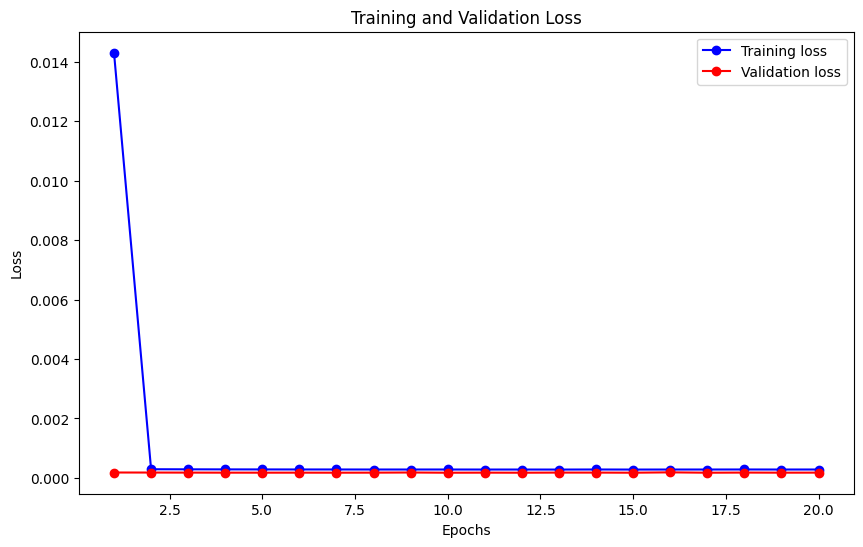

In [38]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [39]:
# Get predictions
pred_VARNN = VARNN_model.predict(testX)

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


In [40]:
def reverse_difference(original_data, differenced_data, order=1):
    reversed_data = []
    last_original_value = original_data.iloc[-len(differenced_data) - order:-order].values
    for i in range(len(differenced_data)):
        restored = differenced_data[i] + last_original_value[i]
        reversed_data.append(restored)
    return np.array(reversed_data)

In [41]:
# Reverse the differencing
last_test_values = scaled_test.iloc[p:]
testY_original = reverse_difference(last_test_values, testY)
pred_VARNN_original = reverse_difference(last_test_values, pred_VARNN)

## Model Evaluation
### Scaled data

In [42]:
for i in range(no_columns):
    print(f'MSE for {scaled_test.columns[i]}: {mean_squared_error(testY_original[:, i], pred_VARNN_original[:, i])}')
    
print(f'MSE total: {mean_squared_error(testY_original, pred_VARNN_original)}')

MSE for gold: 0.00047428705147467554
MSE for oil: 0.0005010385066270828
MSE for us_dollar: 0.00022586066916119307
MSE for usd_vnd: 2.8871052563772537e-05
MSE for cpi: 2.3063375920173712e-05
MSE for inflation_rate: 0.001066148397512734
MSE for interest_rate: 0.00016818067524582148
MSE total: 0.00035535002825781703


In [43]:
for i in range(no_columns):
    rmse = np.sqrt(mean_squared_error(testY_original[:, i], pred_VARNN_original[:, i]))
    print(f'RMSE for {scaled_test.columns[i]}: {rmse}')

total_rmse = np.sqrt(mean_squared_error(testY_original, pred_VARNN_original))
print(f'RMSE total: {total_rmse}')

RMSE for gold: 0.02177813241475668
RMSE for oil: 0.02238388944368433
RMSE for us_dollar: 0.015028661589150016
RMSE for usd_vnd: 0.005373178999788909
RMSE for cpi: 0.004802434374374491
RMSE for inflation_rate: 0.03265192792949191
RMSE for interest_rate: 0.012968449222857044
RMSE total: 0.018850730178372854


In [44]:
for i in range(no_columns):
    print(f'MAE for {scaled_test.columns[i]}: {mean_absolute_error(testY_original[:, i], pred_VARNN_original[:, i])}')
    
print(f'MAE total: {mean_absolute_error(testY_original, pred_VARNN_original)}')

MAE for gold: 0.012878760695457458
MAE for oil: 0.013725345022976398
MAE for us_dollar: 0.009529856033623219
MAE for usd_vnd: 0.0028715466614812613
MAE for cpi: 0.0019582174718379974
MAE for inflation_rate: 0.006055327598005533
MAE for interest_rate: 0.0033400654792785645
MAE total: 0.007194154895842075


### Original data

In [45]:
def unscale(data):
    temp = data.copy()
    for index, i in enumerate(train_df.columns):
        scaler = scalers['scaler_' + i]
        temp[:, index] = scaler.inverse_transform(np.reshape(data[:, index], (-1, 1))).flatten()
    return temp

In [46]:
unscaled_VARNN = unscale(pred_VARNN_original)
originY = unscale(testY_original)

In [47]:
for i in range(no_columns):
    print(f'MSE for {scaled_test.columns[i]}: {mean_squared_error(originY[:, i], unscaled_VARNN[:, i])}')
    
print(f'MSE total: {mean_squared_error(originY, unscaled_VARNN)}')

MSE for gold: 318.13323974609375
MSE for oil: 2.2683372497558594
MSE for us_dollar: 0.1406327486038208
MSE for usd_vnd: 1102.6573486328125
MSE for cpi: 0.06095490604639053
MSE for inflation_rate: 0.0027293392922729254
MSE for interest_rate: 0.001760049257427454
MSE total: 203.32359313964844


In [48]:
for i in range(no_columns):
    rmse = np.sqrt(mean_squared_error(originY[:, i], unscaled_VARNN[:, i]))
    print(f'RMSE for {scaled_test.columns[i]}: {rmse}')

total_rmse = np.sqrt(mean_squared_error(originY, unscaled_VARNN))
print(f'RMSE total: {total_rmse}')

RMSE for gold: 17.836289965855954
RMSE for oil: 1.50610001319828
RMSE for us_dollar: 0.3750103313294459
RMSE for usd_vnd: 33.206284776120505
RMSE for cpi: 0.24689047378623286
RMSE for inflation_rate: 0.05224307889350441
RMSE for interest_rate: 0.04195294098662755
RMSE total: 14.259158219882702


In [49]:
for i in range(no_columns):
    print(f'MAE for {scaled_test.columns[i]}: {mean_absolute_error(originY[:, i], unscaled_VARNN[:, i])}')
    
print(f'MAE total: {mean_absolute_error(originY, unscaled_VARNN)}')

MAE for gold: 10.547703742980957
MAE for oil: 0.9235097169876099
MAE for us_dollar: 0.2377985566854477
MAE for usd_vnd: 17.746200561523438
MAE for cpi: 0.10067042708396912
MAE for inflation_rate: 0.009688522666692734
MAE for interest_rate: 0.010805146768689156
MAE total: 4.225193977355957


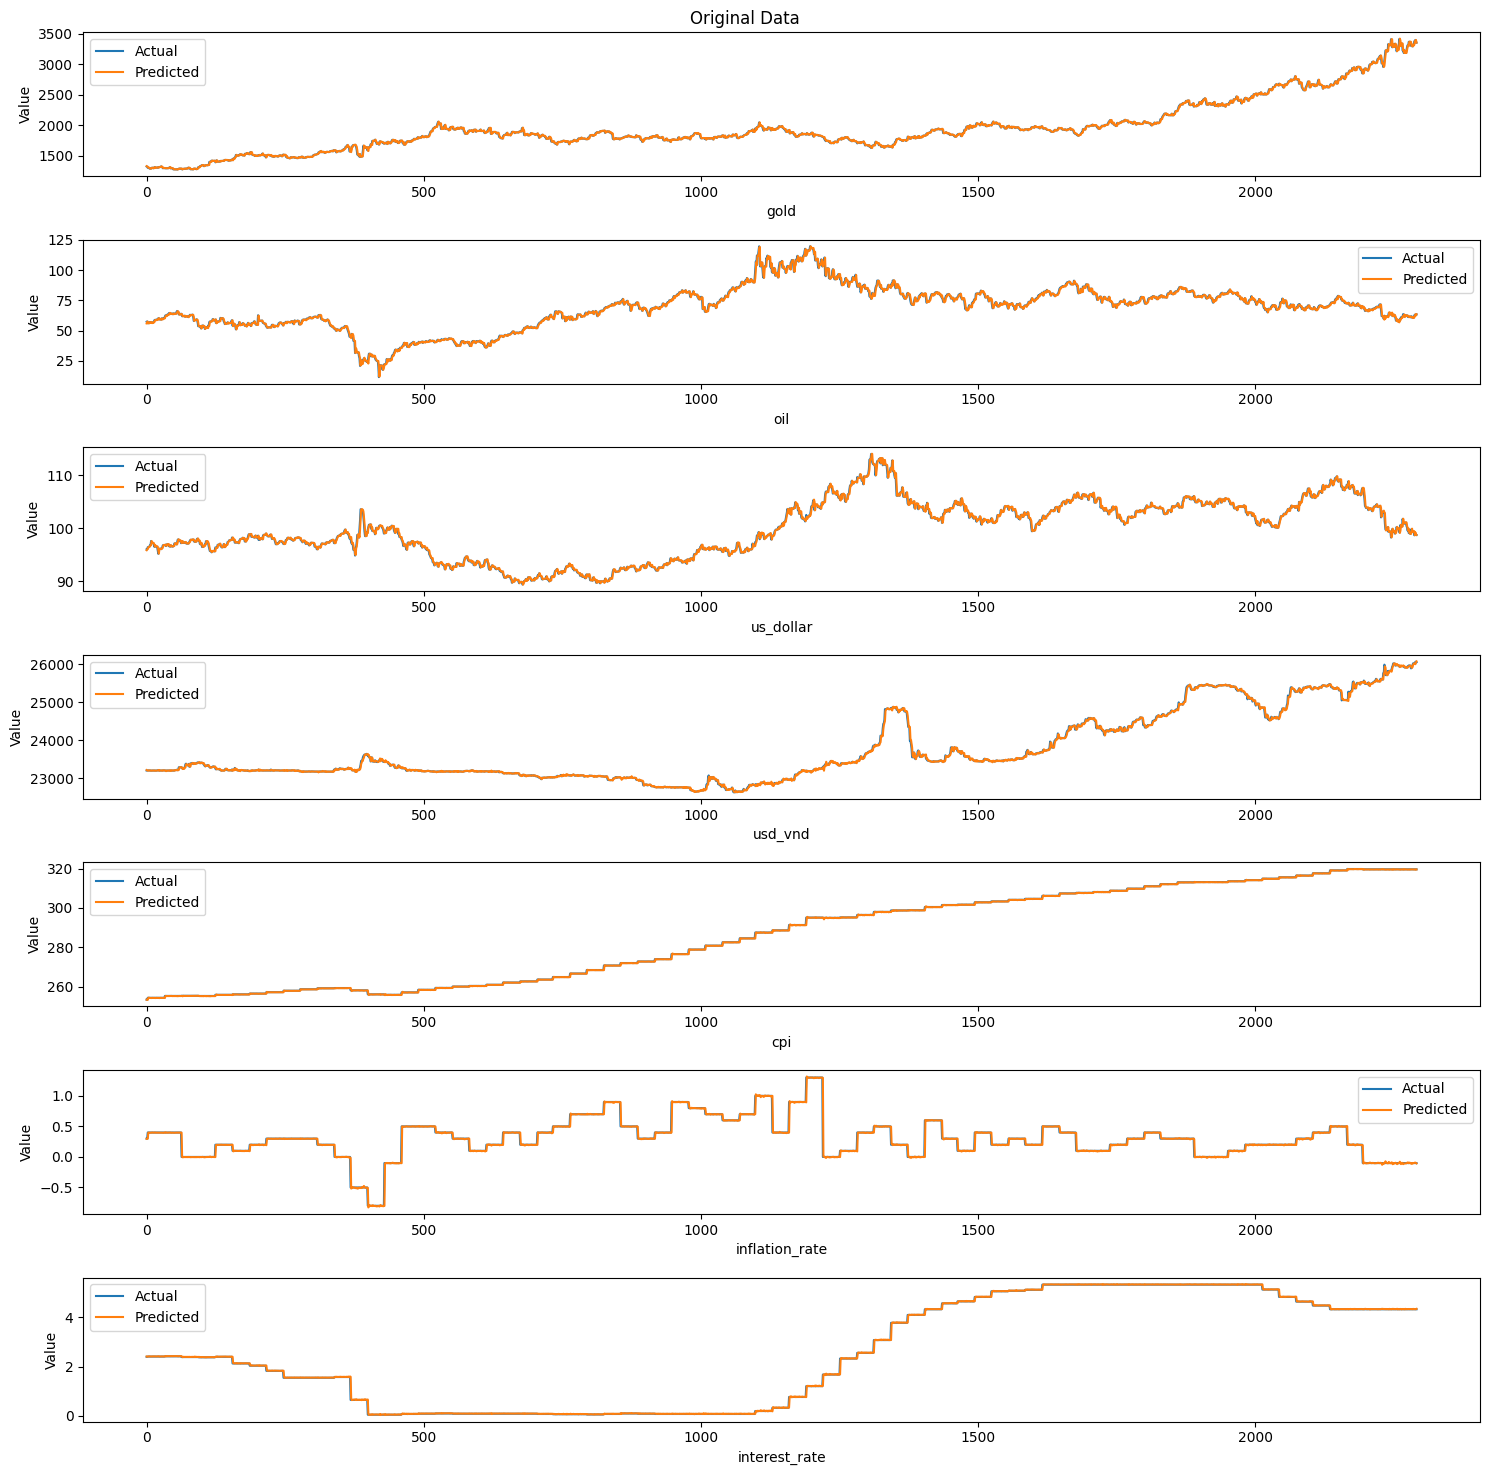

In [50]:
plt.figure(figsize=(15, 15))
for i in range(no_columns):
    plt.subplot(no_columns, 1, i+1)
    plt.plot(originY[:, i], label='Actual')
    plt.plot(unscaled_VARNN[:, i], label='Predicted')
    plt.title('')
    plt.xlabel(f'{scaled_test.columns[i]}')
    plt.ylabel('Value')
    plt.legend()
    
plt.suptitle('Original Data')
plt.tight_layout()
plt.show()

In [48]:
len(testX)

2196